# Data Science Charcuterie: Classification

#### Kate Stadelman

The following notebook showcases different classification techniques on the Mushroom dataset. Please note that this is a data mining exercise to get you used to classification algorithms and metrics. For a predictive model, there is a more complex process of data splitting and evaluation that is covered in other repos.

In [1]:
import pandas as pd
import numpy as np

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# classification
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import plot_tree
import shap

## Introduction

Our quest is to develop a mushroom stew that is visually appealing, pleasingly smelling, and preferably non-toxic.

In order to identify mushroom features that will benefit the stew, and most importantly, prevent us from poisoning ourselves and others, we will take the following steps:
* Find and load the mushroom dataset
* Perform exploratory data analysis
* Implement classification techniques

## Mushroom Data

Our mushroom dataset was downloaded from Kaggle (https://www.kaggle.com/uciml/mushroom-classification). We load the data to a dataframe, and take a first look. This is an exceptionally clean dataset with all attributes populated for every row.


UCI provides some additional information on the data: "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended.  This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like 'leaflets three, let it be' for Poisonous Oak and Ivy."


In [2]:
df = pd.read_csv('mushrooms.csv')
df.sample(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
1522,e,x,s,w,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
1255,e,x,s,w,f,n,f,w,b,p,...,s,w,w,p,w,o,e,n,a,g
4607,p,f,f,y,f,f,f,c,b,h,...,k,n,n,p,w,o,l,h,y,d
7897,p,f,y,n,f,s,f,c,n,b,...,s,w,p,p,w,o,e,w,v,d
4004,p,x,y,g,f,f,f,c,b,g,...,k,n,p,p,w,o,l,h,y,p
772,e,x,y,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,k,n,m
4366,p,x,y,y,f,f,f,c,b,p,...,k,b,p,p,w,o,l,h,y,p
1863,e,x,f,g,t,n,f,c,b,w,...,s,p,w,p,w,o,p,n,y,d
1731,p,x,s,n,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,v,u
1860,e,x,f,e,t,n,f,c,b,u,...,s,g,g,p,w,o,p,n,y,d


In [3]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [4]:
df = df.astype('category')
df.dtypes


class                       category
cap-shape                   category
cap-surface                 category
cap-color                   category
bruises                     category
odor                        category
gill-attachment             category
gill-spacing                category
gill-size                   category
gill-color                  category
stalk-shape                 category
stalk-root                  category
stalk-surface-above-ring    category
stalk-surface-below-ring    category
stalk-color-above-ring      category
stalk-color-below-ring      category
veil-type                   category
veil-color                  category
ring-number                 category
ring-type                   category
spore-print-color           category
population                  category
habitat                     category
dtype: object

Because all of the mushrooms features are abbreviated, it is a bit difficult to interpret the data without a key. We create a translation dictionary to aid us in exploratory data anlysis.

In [5]:
# make a readable version of the data for EDA
mushroom_data = {
    'class': { 'e': 'edible', 'p': 'poisonous' }
    ,'cap-shape': { 'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken' }
    ,'cap-surface': { 'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth' }
    ,'cap-color': { 'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow' }
    ,'bruises': { 't': 'bruises', 'f': 'no' }
    ,'odor': { 'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy' }
    ,'gill-attachment': { 'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched' }
    ,'gill-spacing': { 'c': 'close', 'w': 'crowded', 'd': 'distant' }
    ,'gill-size': { 'b': 'broad', 'n': 'narrow' }
    ,'gill-color': { 'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow' }
    ,'stalk-shape': { 'e': 'enlarging', 't': 'tapering' }
    ,'stalk-root': { 'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing' }
    ,'stalk-surface-above-ring': { 'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth' }
    ,'stalk-surface-below-ring': { 'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth' }
    ,'stalk-color-above-ring': { 'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow' }
    ,'stalk-color-below-ring': { 'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow' }
    ,'veil-type': { 'p': 'partial', 'u': 'universal' }
    ,'veil-color': { 'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow' }
    ,'ring-number': { 'n': 'none', 'o': 'one', 't': 'two' }
    ,'ring-type': { 'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone' }
    ,'spore-print-color': { 'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow' }
    ,'population': { 'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary' }
    ,'habitat': { 'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods' }
}
features = list(mushroom_data.keys())[1:]

mushroom_df = df.copy()
for key in mushroom_data:
    mushroom_df[key] = mushroom_df[key].apply( lambda x: mushroom_data[key][str(x)] )
mushroom_df.sample(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
8109,edible,bell,smooth,white,no,none,free,crowded,broad,white,...,smooth,white,white,partial,white,two,pendant,white,numerous,grasses
7113,poisonous,knobbed,smooth,brown,no,foul,free,close,narrow,buff,...,silky,white,pink,partial,white,one,evanescent,white,several,paths
2005,edible,convex,scaly,yellow,bruises,anise,free,close,broad,brown,...,scaly,white,white,partial,white,one,pendant,brown,scattered,grasses
1142,edible,flat,fibrous,white,no,none,free,crowded,broad,chocolate,...,fibrous,white,white,partial,white,one,evanescent,brown,scattered,grasses
2067,poisonous,flat,smooth,brown,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,several,urban
7655,poisonous,knobbed,smooth,brown,no,fishy,free,close,narrow,buff,...,silky,white,pink,partial,white,one,evanescent,white,several,paths
3889,poisonous,convex,fibrous,gray,no,foul,free,close,broad,chocolate,...,silky,brown,buff,partial,white,one,large,chocolate,several,woods
6683,poisonous,flat,smooth,red,no,foul,free,close,narrow,buff,...,silky,white,white,partial,white,one,evanescent,white,several,leaves
997,edible,flat,smooth,white,bruises,almond,free,crowded,narrow,white,...,smooth,white,white,partial,white,one,pendant,purple,several,woods
7958,edible,knobbed,fibrous,white,no,none,free,crowded,broad,gray,...,smooth,white,white,partial,white,two,pendant,white,numerous,grasses


Much better! The data is ready for analysis.

## Exploratory Data Analysis

Starting with a simple description of the data, we can see that certain features, like odor and gill-color take on a number of different values, while veil-color only has a single value (and thus can be removed during classification). Also, the top value of certain features, such as veil-color and gill-attachment, clearly dominates that feature (~97% of all observations), unlike gill-color whose top value only accounts for 21% of the observations.

In [6]:
mushroom_df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,edible,convex,scaly,brown,no,none,free,close,broad,buff,...,smooth,white,white,partial,white,one,pendant,white,several,woods
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


The mushrooms are about evenly split between edible and poisonous.

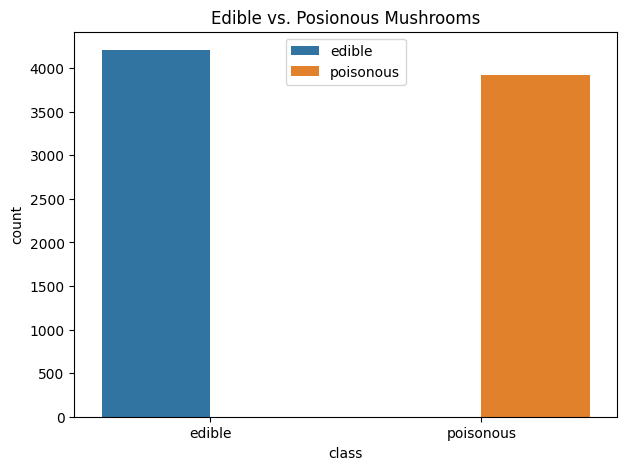

In [7]:
fig = plt.figure(figsize=(7,5))
sns.countplot(x='class', hue='class', data=mushroom_df).set(title='Edible vs. Posionous Mushrooms')
plt.legend(loc='upper center')
plt.show()

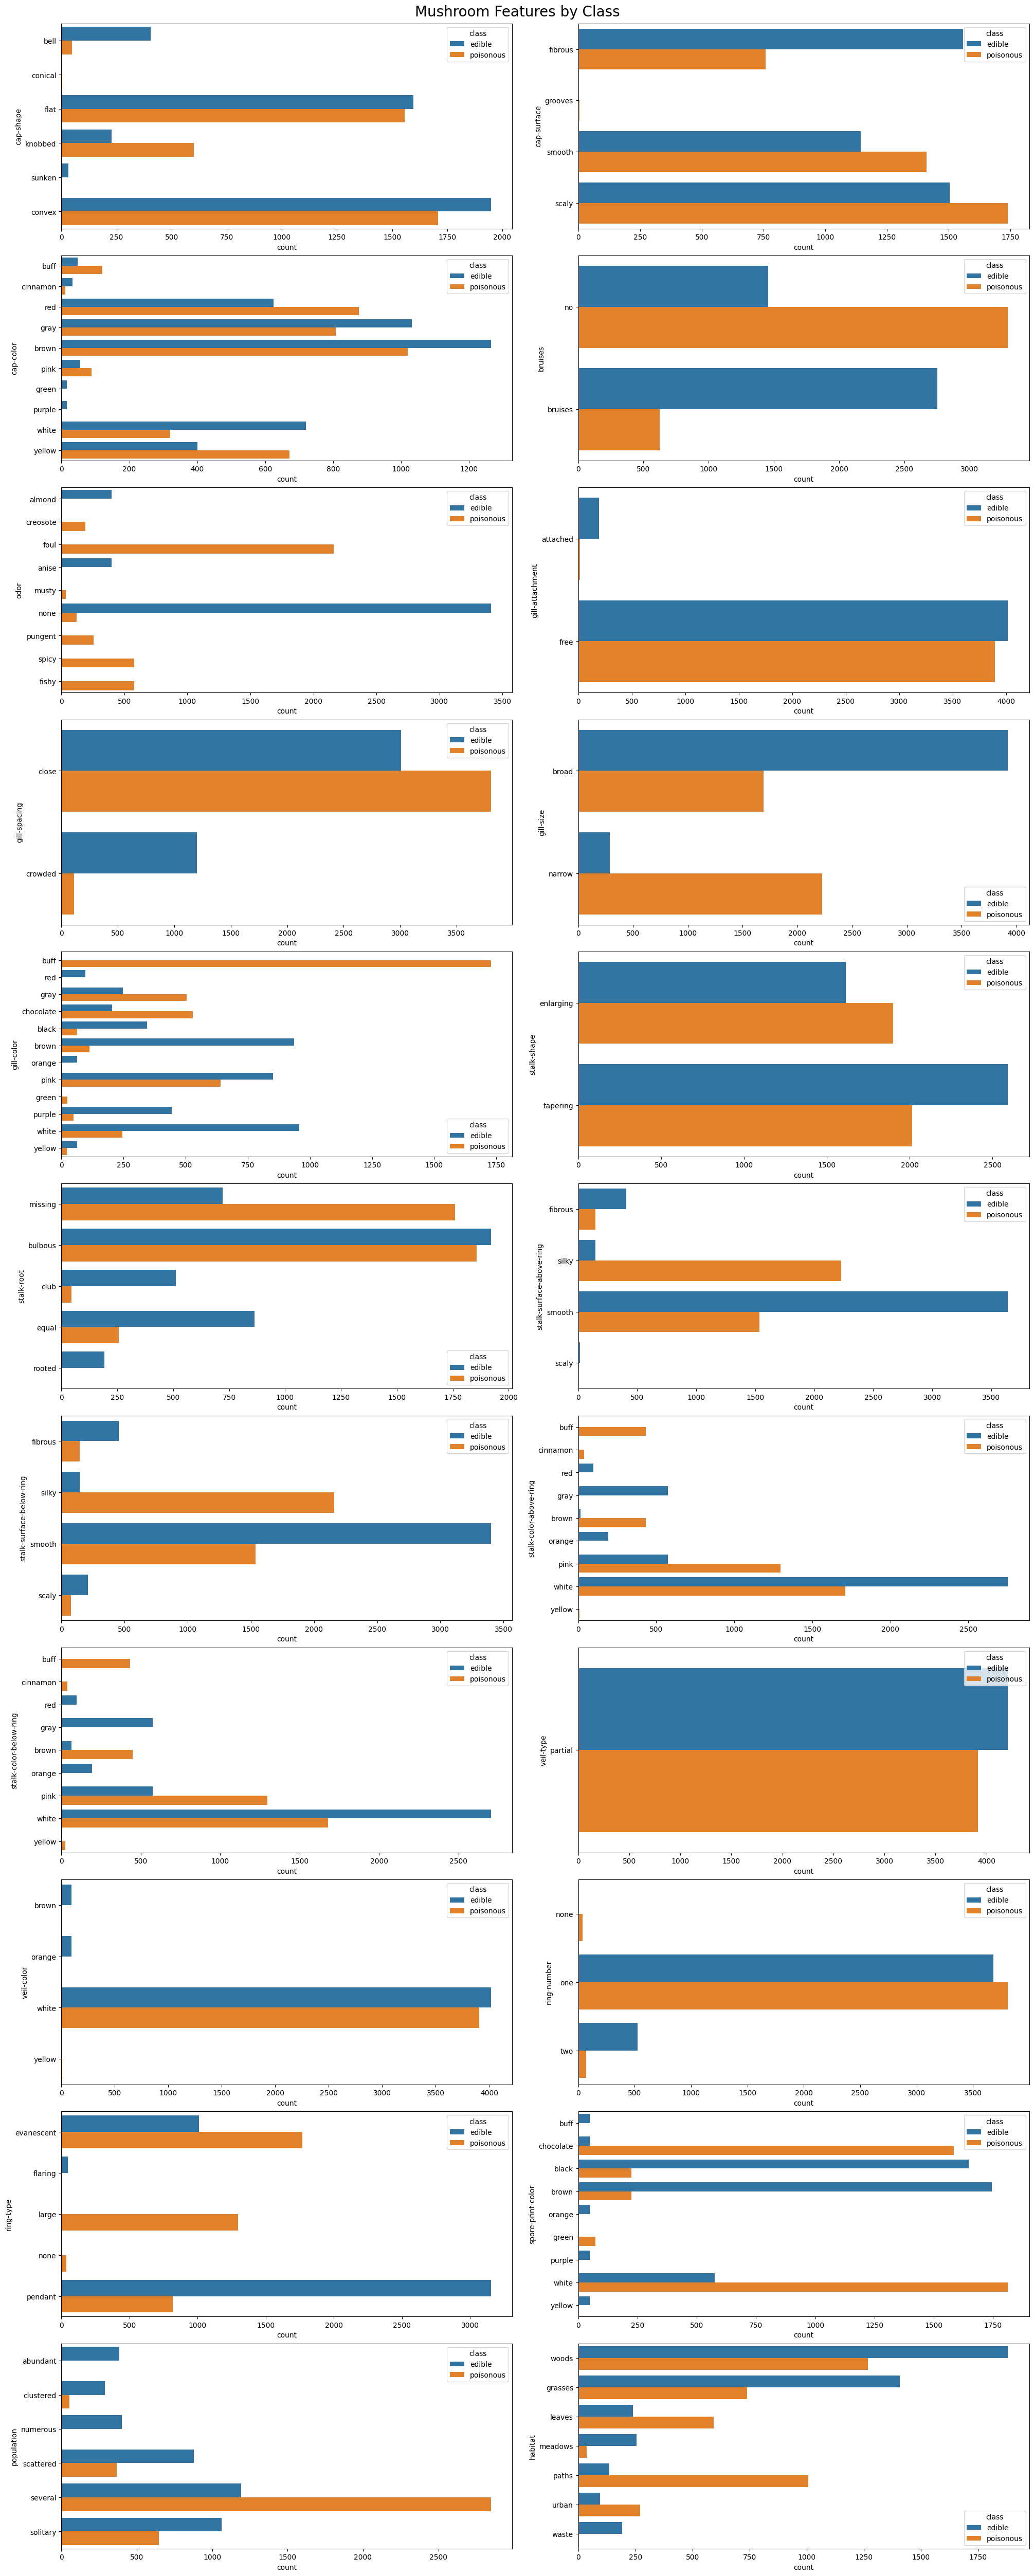

In [8]:
l,w = 11,2
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(20,50))
fig.suptitle('Mushroom Features by Class', fontsize=20)
for i in range(len(features)):
    j,k = plots[i]
    sns.countplot(y=features[i], hue='class', data=mushroom_df, ax=axs[j,k])
plt.show()

In terms of tastiness and flavor for our stew, our best approximation is mushroom odor. Interestingly, all of the "bad" odors (foul, creosote, fishy, musty, and pungent) are poisonous, so if we ensure our selected mushrooms are edible, we ensure our mushroom stew has neutral or pleasantly smelling odor. In terms of cap-color, gill-color, veil-color, and spore-print-color, there appears to be a wide variety of both the edible and poisonous varieties to make our stew visiually appealing.

## Classification Data Prep

In reading a number of articles, there are varying opinions about whether it is necessary to one-hot encode all categorical variables for classification, or if label encoding is sufficient. Additionally, some classification methods like Random Forest have been shown to be less affected by multicollinearity, so it not necessarily required to drop the first case of each categorical variable when one-hot encoding. In cases where there a large number of categorical variables with each having a number of distinct values, as we have in the mushroom dataset, it is difficult to trace back and determine which value was dropped from each variable. Being able to leave in all values of categorical variables helps with model explainability.

Because of the differing opinions, we will test each classification methodology using both label encoding and one-hot encoding (with all columns retained), and compare results.

### Label Encoded Data Set

In [9]:
label_df = mushroom_df.copy()
label_df['class'] = label_df['class'].apply(lambda x: 1 if x == 'edible' else 0)
label_df.drop(columns=['veil-type'], inplace=True)                                                # drop because variable only has one value
label_df['bruises'] = label_df['bruises'].apply(lambda x: 1 if x == 'bruises' else 0)             # handset variables with only two options
label_df['gill-attachment'] = label_df['gill-attachment'].apply(lambda x: 1 if x == 'attached' else 0)
label_df['gill-size'] = label_df['gill-size'].apply(lambda x: 1 if x == 'broad' else 0)
label_df['gill-spacing'] = label_df['gill-spacing'].apply(lambda x: 1 if x == 'crowded' else 0)
label_df['ring-number'] = label_df['ring-number'].apply(lambda x: 0 if str(x)=='none' else (1 if str(x)=='one' else 2))
label_df['stalk-shape'] = label_df['stalk-shape'].apply(lambda x: 1 if x == 'tapering' else 0)

le = preprocessing.LabelEncoder()
for column in ['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
               'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-type', 'spore-print-color', 'population', 'habitat']:
    label_df[column] = le.fit_transform(label_df[column])

label_df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,2,3,0,1,7,0,0,0,0,...,3,3,7,7,2,1,4,0,3,4
1,1,2,3,9,1,0,0,0,1,0,...,3,3,7,7,2,1,4,1,2,0
2,1,0,3,8,1,1,0,0,1,1,...,3,3,7,7,2,1,4,1,2,2
3,0,2,2,8,1,7,0,0,0,1,...,3,3,7,7,2,1,4,0,3,4
4,1,2,3,3,0,6,0,1,1,0,...,3,3,7,7,2,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,4,3,0,0,6,1,0,1,11,...,3,3,4,4,1,1,4,2,1,1
8120,1,2,3,0,0,6,1,0,1,11,...,3,3,4,4,0,1,4,2,4,1
8121,1,3,3,0,0,6,1,0,1,1,...,3,3,4,4,1,1,4,2,1,1
8122,0,4,2,0,0,3,0,0,0,2,...,3,2,7,7,2,1,0,7,4,1


In [10]:
label_features = label_df.columns[1:]
X_label = label_df[label_df.columns[1:]].to_numpy()

rs = RobustScaler()
X_label = rs.fit_transform(X_label)

y = label_df['class']

### One-Hot Encoded Data Set

In [11]:
onehot_df = mushroom_df.copy()
onehot_df['class'] = onehot_df['class'].apply(lambda x: 1 if x == 'edible' else 0)
onehot_df.drop(columns=['veil-type'], inplace=True)                                                # drop because variable only has one value
onehot_df['bruises'] = onehot_df['bruises'].apply(lambda x: 1 if x == 'bruises' else 0)             # handset variables with only two options
onehot_df['gill-attachment'] = onehot_df['gill-attachment'].apply(lambda x: 1 if x == 'attached' else 0)
onehot_df['gill-size'] = onehot_df['gill-size'].apply(lambda x: 1 if x == 'broad' else 0)
onehot_df['gill-spacing'] = onehot_df['gill-spacing'].apply(lambda x: 1 if x == 'crowded' else 0)
onehot_df['stalk-shape'] = onehot_df['stalk-shape'].apply(lambda x: 1 if x == 'tapering' else 0)

onehot_df = pd.get_dummies(onehot_df, columns=['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color', 'stalk-root', 'stalk-surface-above-ring',
                                               'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number',
                                               'ring-type', 'spore-print-color', 'population', 'habitat'])

onehot_df

,class,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_bell,cap-shape_conical,cap-shape_flat,cap-shape_knobbed,...,population_scattered,population_several,population_solitary,habitat_woods,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8120,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
8121,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8122,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [12]:
onehot_features = onehot_df.columns[1:]
X_onehot = onehot_df[onehot_df.columns[1:]].to_numpy()

# Random Forest

First proposed in 1995, Random Forest is an tree-based, ensemble method that employs bagging. This means the data is randomly sampled with replacement over and over again (bagging) to create many decision trees. For classification, the class identified by the most trees for an observation wins (ensemble method). 

We try Random Forest using both the label encoded and one-hot encoded data.


In [13]:
# label encoded
rf_label = RandomForestClassifier(n_estimators=200)
rf_label.fit(X_label, y)
y_label_rf = rf_label.predict(X_label)

# one-hot encoded
rf_onehot = RandomForestClassifier(n_estimators=200)
rf_onehot.fit(X_onehot, y)
y_onehot_rf = rf_onehot.predict(X_onehot)

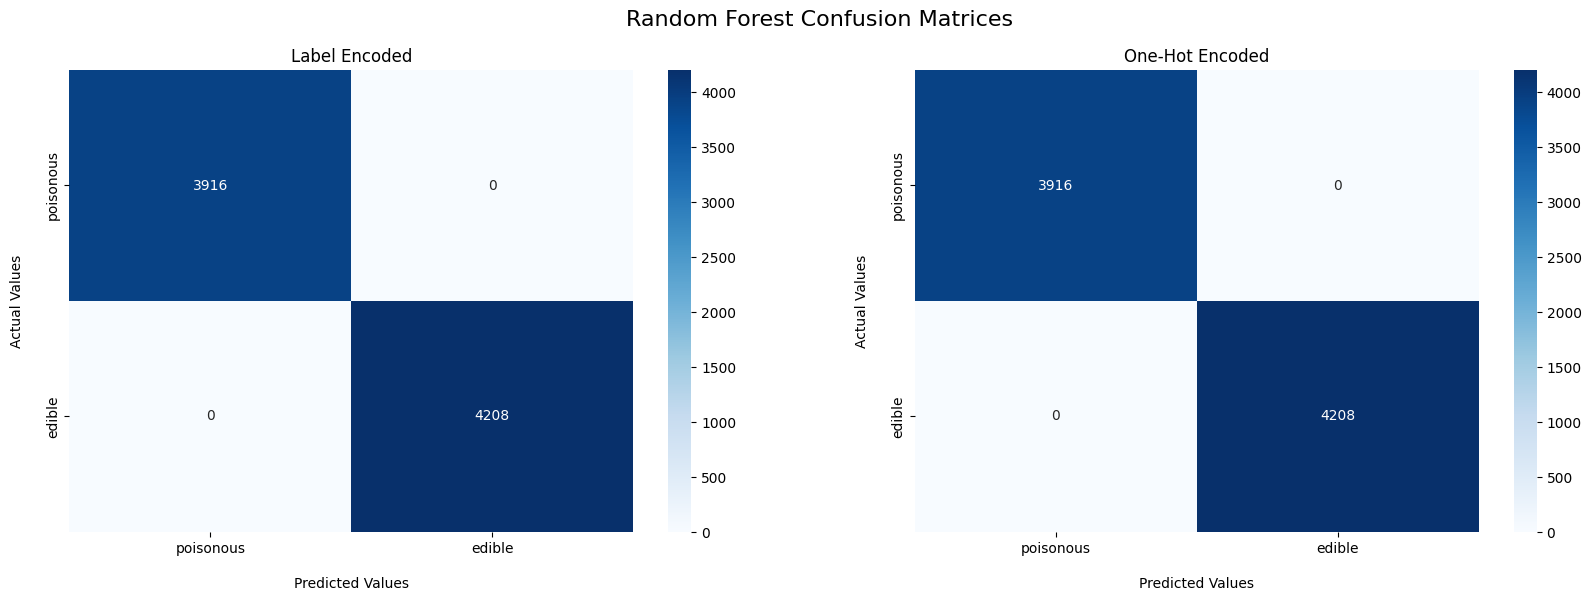

In [14]:
# confusion matrices
rf_label_cm = confusion_matrix(y, y_label_rf)
rf_onehot_cm = confusion_matrix(y, y_onehot_rf)

fig, axs = plt.subplots(1, 2, figsize = (20,6))
fig.suptitle('Random Forest Confusion Matrices\n\n', fontsize=16)
sns.heatmap(rf_label_cm, annot=True, cmap='Blues', fmt='g', ax = axs[0])
axs[0].set_title('Label Encoded')
axs[0].set_xlabel('\nPredicted Values')
axs[0].set_ylabel('Actual Values\n')
axs[0].xaxis.set_ticklabels(['poisonous','edible'])
axs[0].yaxis.set_ticklabels(['poisonous','edible'])
sns.heatmap(rf_onehot_cm, annot=True, cmap='Blues', fmt='g', ax=axs[1])
axs[1].set_title('One-Hot Encoded')
axs[1].set_xlabel('\nPredicted Values')
axs[1].set_ylabel('Actual Values\n')
axs[1].xaxis.set_ticklabels(['poisonous','edible'])
axs[1].yaxis.set_ticklabels(['poisonous','edible'])
plt.show()



In [15]:
# classification report
print('Random Forest Classification Reports\n\n')
print('Label Encoded\n')
print(classification_report(y, y_label_rf, target_names=['poisonous','edible']))
print('\n\nOne-Hot Encoded\n')
print(classification_report(y, y_onehot_rf, target_names=['poisonous','edible']))

Random Forest Classification Reports


Label Encoded

              precision    recall  f1-score   support

   poisonous       1.00      1.00      1.00      3916
      edible       1.00      1.00      1.00      4208

    accuracy                           1.00      8124
   macro avg       1.00      1.00      1.00      8124
weighted avg       1.00      1.00      1.00      8124



One-Hot Encoded

              precision    recall  f1-score   support

   poisonous       1.00      1.00      1.00      3916
      edible       1.00      1.00      1.00      4208

    accuracy                           1.00      8124
   macro avg       1.00      1.00      1.00      8124
weighted avg       1.00      1.00      1.00      8124



Random Forest perfectly classifying our mushrooms as edible or poisonous, regardless of the encoding method. Please note, that **if we were making a predictive model, 100% accuracy is actually a very bad sign** that our model is overfit. This is a data mining exercise to better understand our data, not a machine learning model. Let's explore which features are the most important for classification, as well as take a look at the generated overall decision tree.

In [16]:
# shap values to find important features
rf_label_explainer = shap.TreeExplainer(rf_label)
rf_label_shap_values = rf_label_explainer.shap_values(X_label)
rf_onehot_explainer = shap.TreeExplainer(rf_onehot)
rf_onehot_shap_values = rf_onehot_explainer.shap_values(X_onehot)


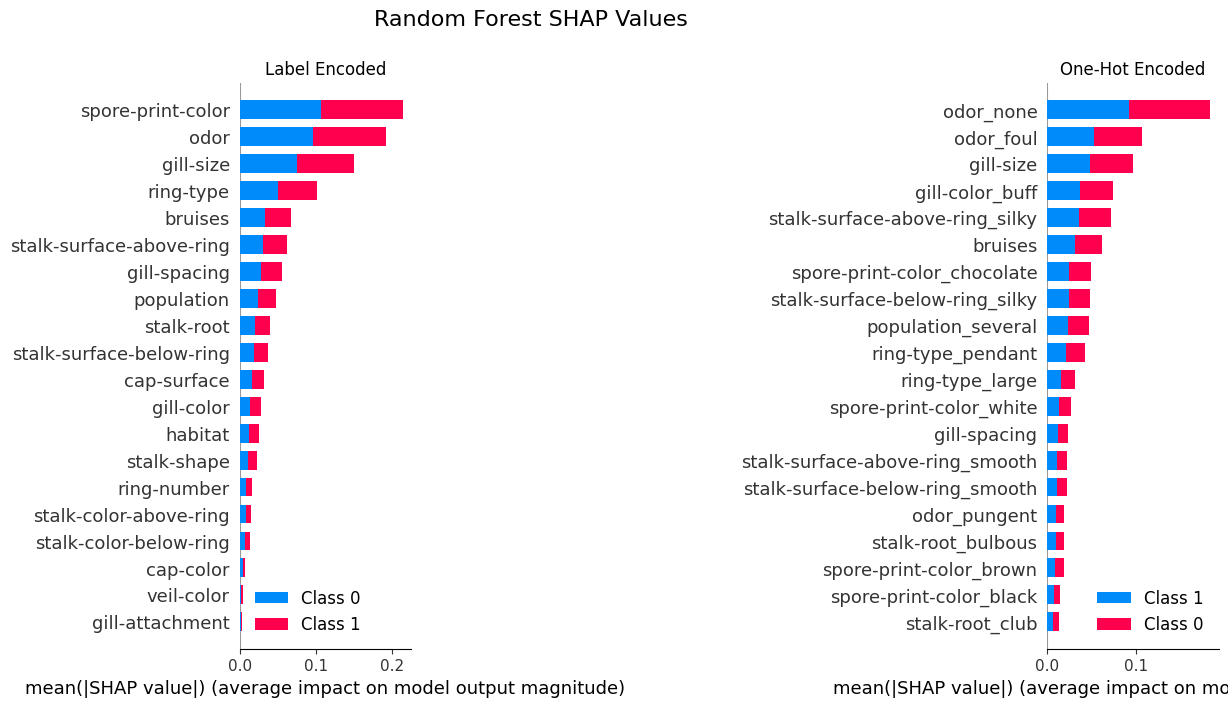

In [17]:
fig = plt.figure()
plt.suptitle('Random Forest SHAP Values\n\n', fontsize=16)
ax1 = fig.add_subplot(121)
shap.summary_plot(rf_label_shap_values, features=X_label, feature_names=label_features, plot_type='bar', show=False)
ax1.title.set_text('Label Encoded')
ax2 = fig.add_subplot(122)
shap.summary_plot(rf_onehot_shap_values, features=X_onehot, feature_names=onehot_features, plot_type='bar', show=False)
ax2.title.set_text('One-Hot Encoded')
plt.tight_layout()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.show()



Per Kaggle, "SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature." Between both the label encoded and one-hot encoded data, we generally see the same features rising to the top of importance: odor, gill-size, ring-type, spore-print-color, and population. However, the one-hot encoded data set appears to provide a more specific ruleset for evaluating each observation: Mushrooms with no odor are typically edible, while those with a foul odor or buff gill-color are all poisonous.

The following decision trees are another tool of model understanding. We notice that the label encoded tree is more difficult to interpret than the one-hot encoded tree because rules like "stalk-surface-below-ring <= -0.5" provide almost no practical use without a reversal of the encoding. On the other hand, the one-hot encoded tree is very crowded with rules since all distinct values of each categorical variable are treated separately.

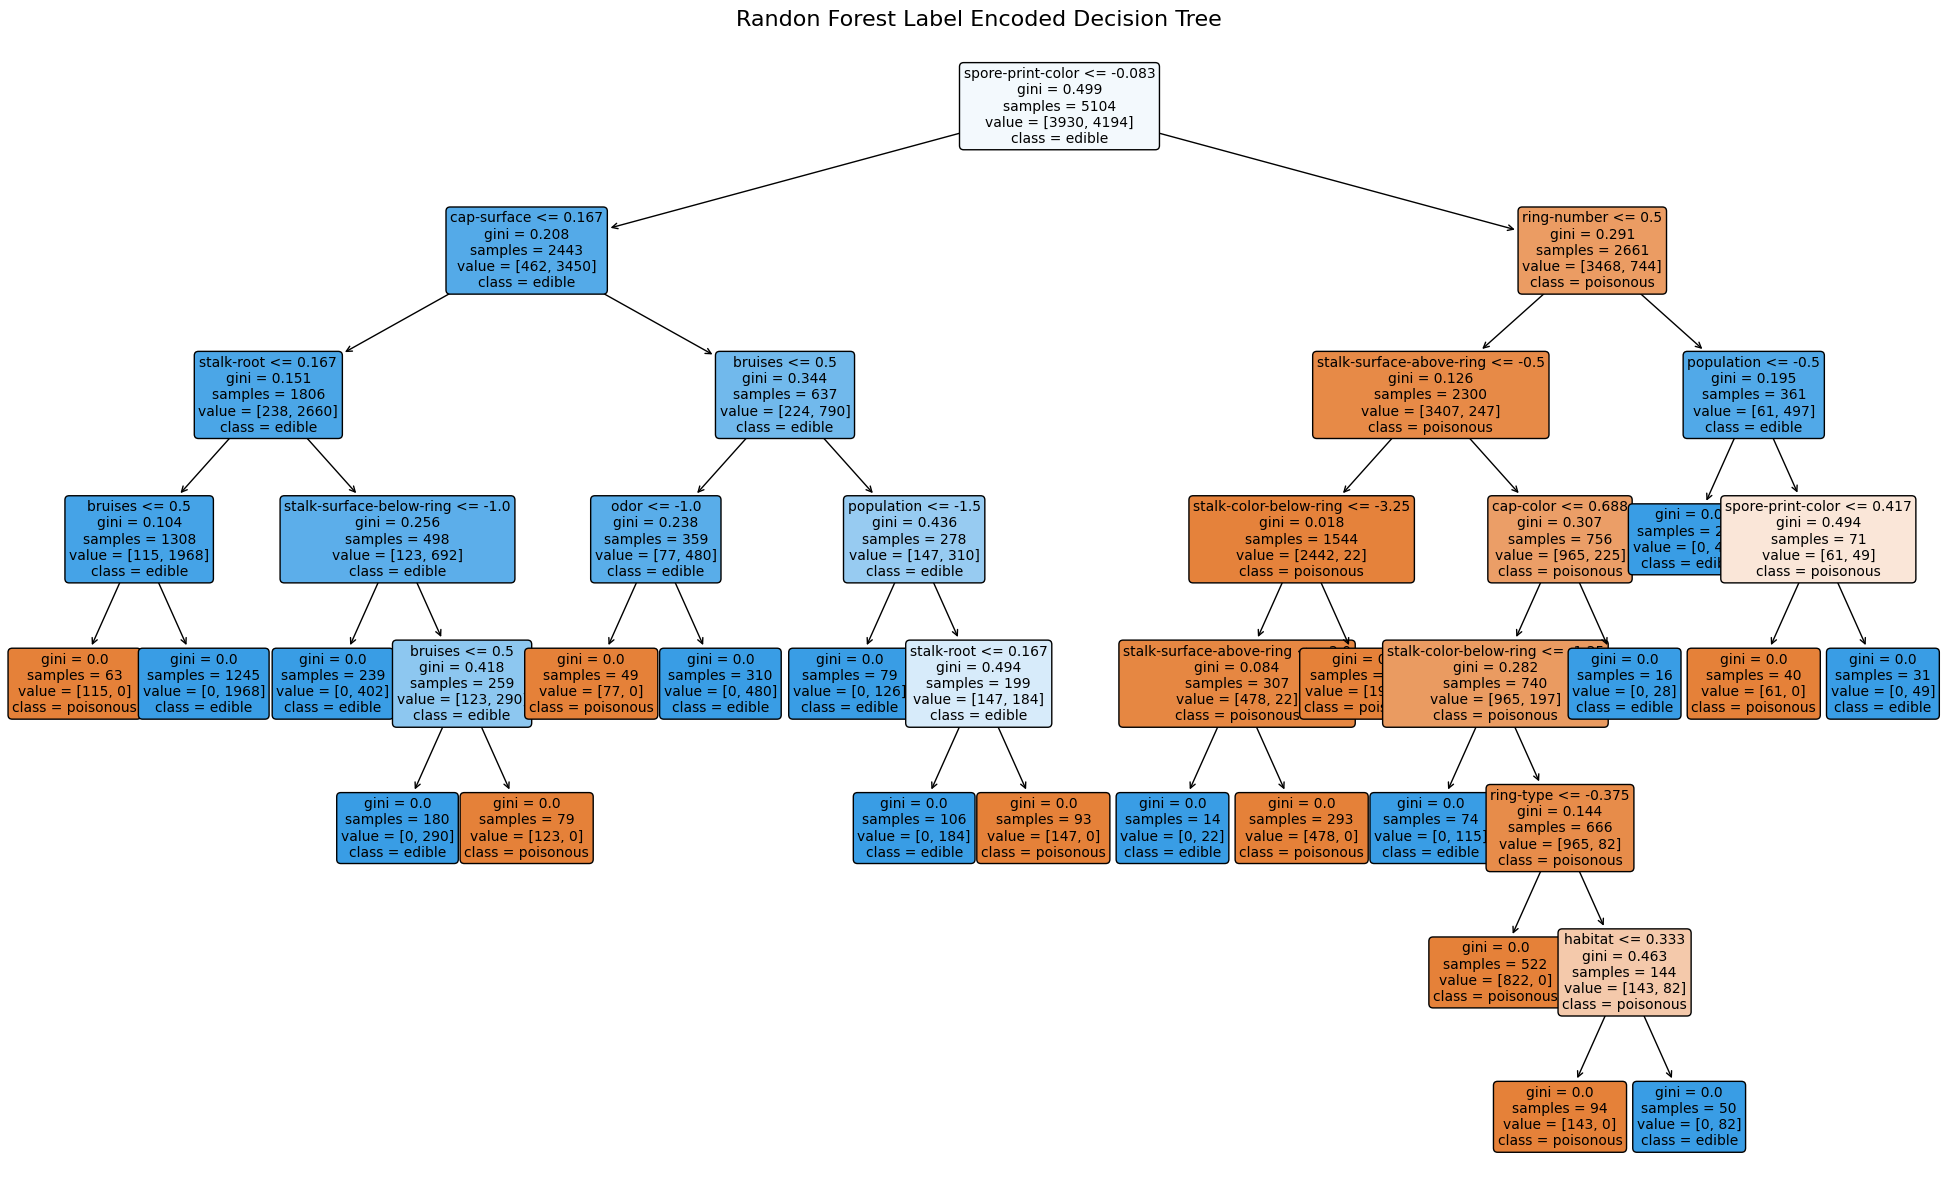

In [18]:
# label encoded decision tree
fig = plt.figure(figsize=(25, 15))
plot_tree(rf_label.estimators_[0], 
          feature_names=label_features,
          class_names=['poisonous','edible'],
          filled=True, 
          impurity=True, 
          rounded=True,
          fontsize=10)
plt.title('Randon Forest Label Encoded Decision Tree', fontsize=16)
plt.show()



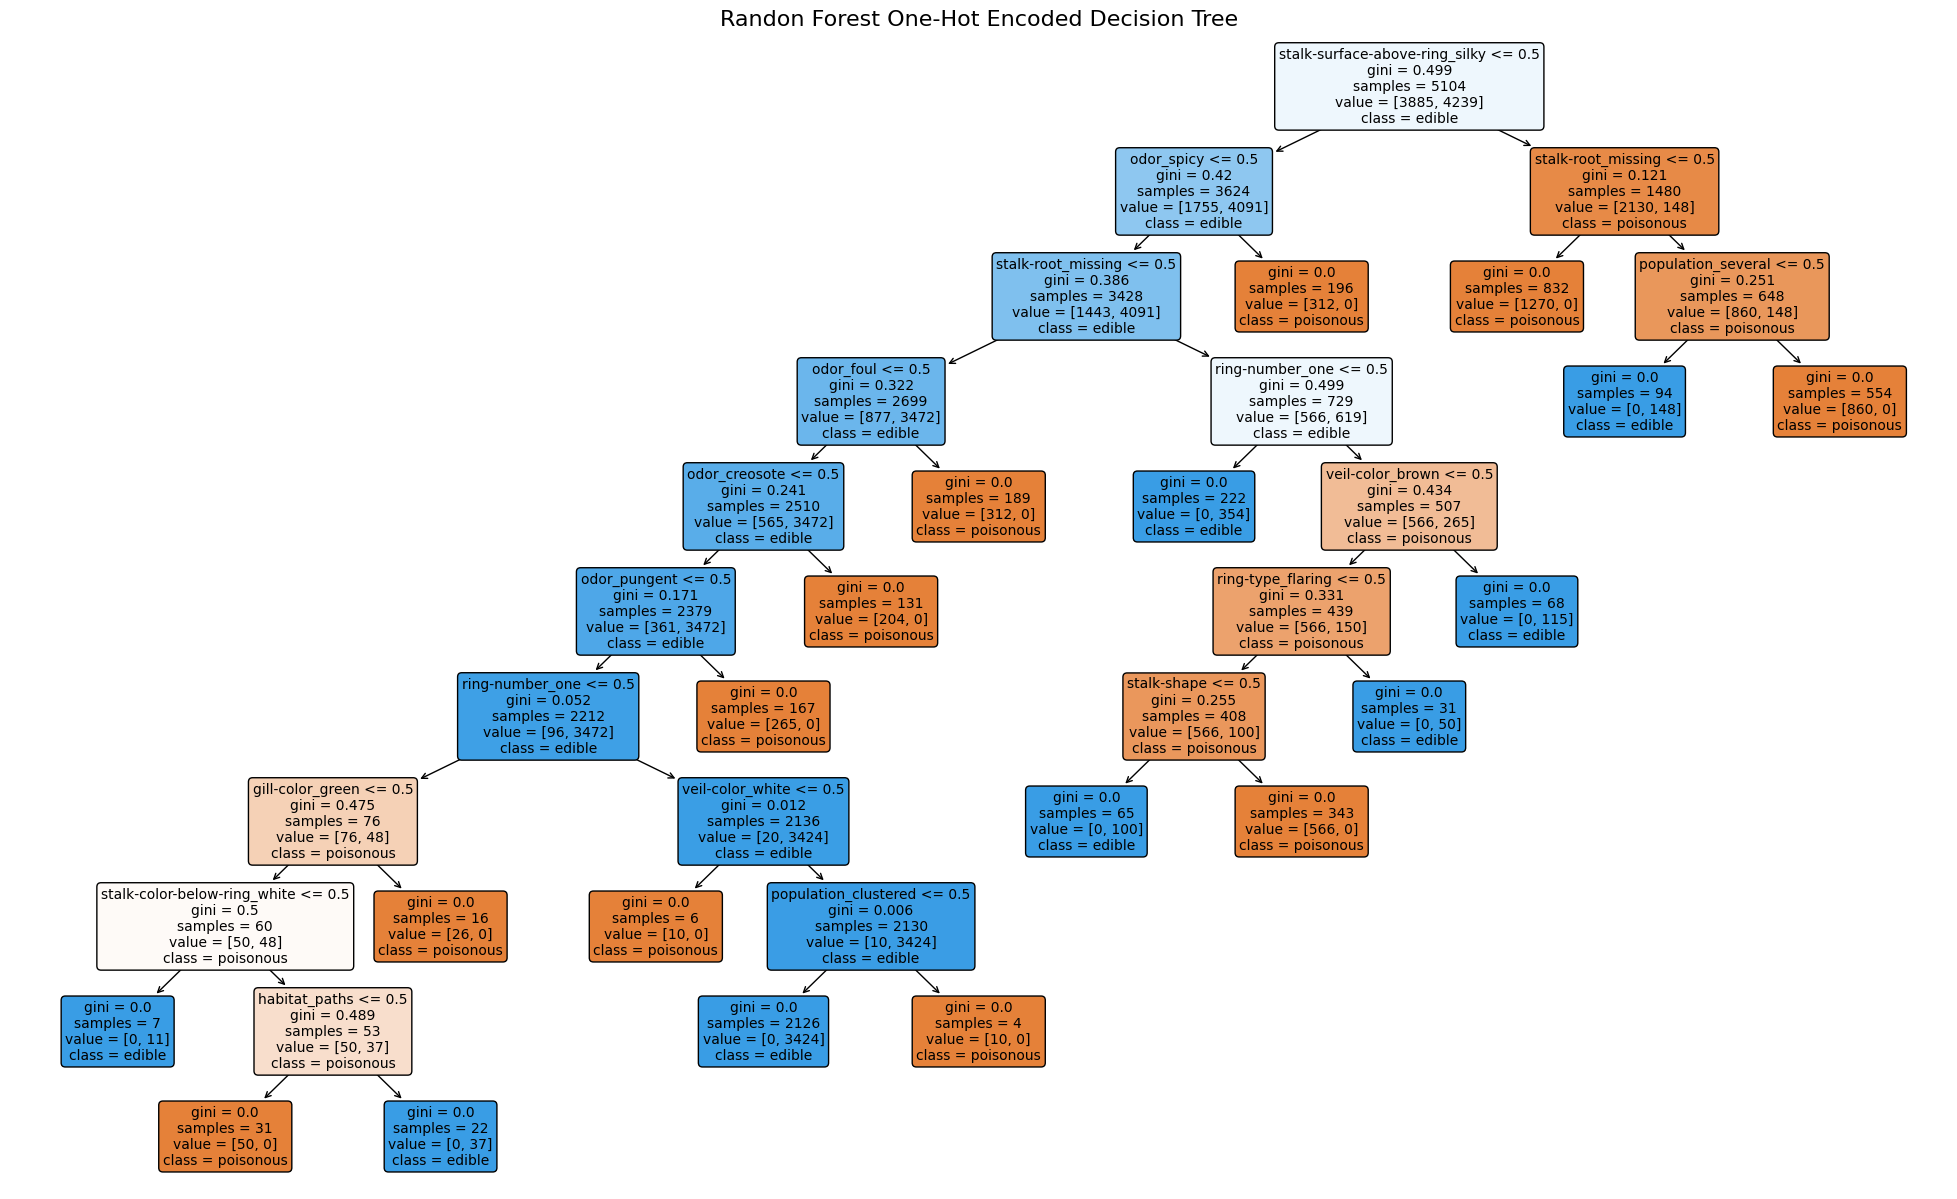

In [19]:
# one-hot encoded decision tree
fig = plt.figure(figsize=(25, 15))
plot_tree(rf_onehot.estimators_[0], 
          feature_names=onehot_features,
          class_names=['poisonous','edible'],
          filled=True, 
          impurity=True, 
          rounded=True,
          fontsize=10)
plt.title('Randon Forest One-Hot Encoded Decision Tree', fontsize=16)
plt.show()

## Support Vector Machines (SVM)

Support Vector Machines (SVM) are a classification method where the gap between margins is optimized using the maximum margin linear discriminants. SVM is a supervised learning method used for classification, regression, and outlier detection. The Sklearn library has extensive notes on the pros and cons of SVMs:

The advantages of support vector machines are:
* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:
* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.



In [20]:
# label encoded
svm_label = SVC(kernel='linear')        # set to linear so we can see coefficients
svm_label.fit(X_label, y)
y_label_svm = svm_label.predict(X_label)

# one-hot encoded
svm_onehot = SVC(kernel='linear')
svm_onehot.fit(X_onehot, y)
y_onehot_svm = svm_onehot.predict(X_onehot)

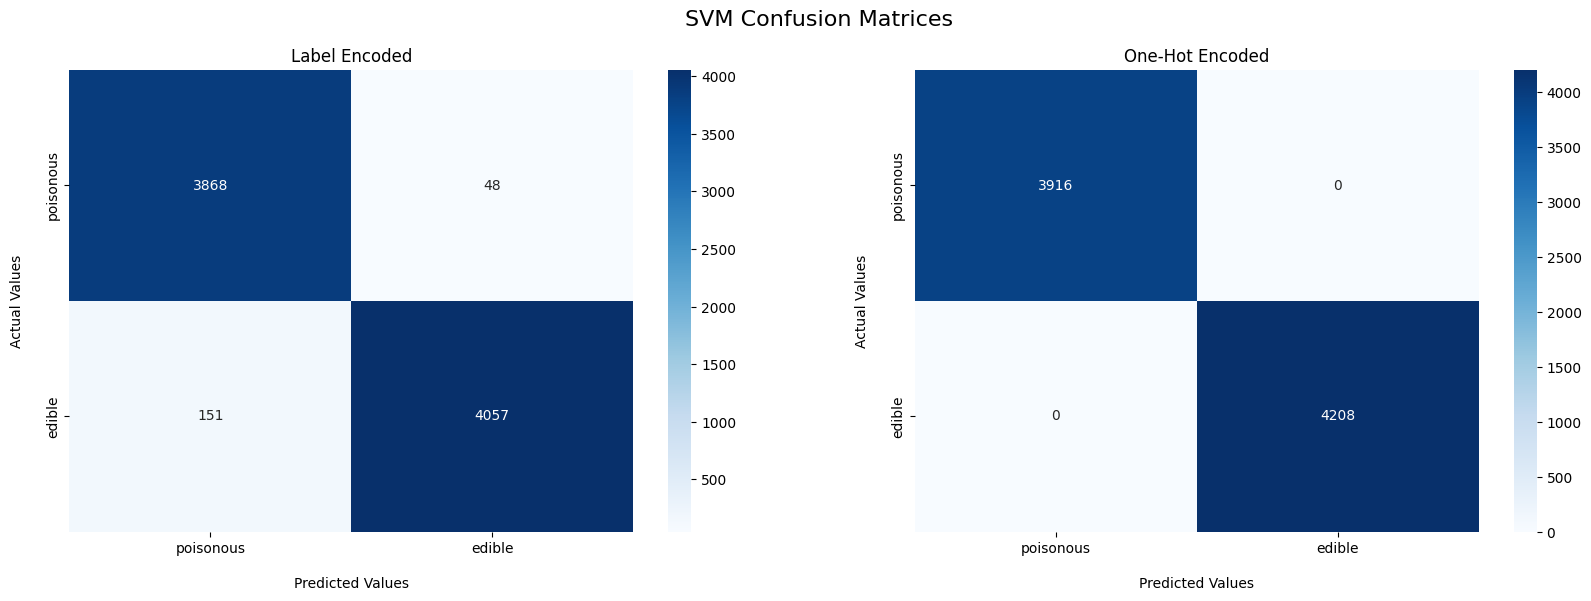

In [21]:
# confusion matrices
svm_label_cm = confusion_matrix(y, y_label_svm)
svm_onehot_cm = confusion_matrix(y, y_onehot_svm)

fig, axs = plt.subplots(1, 2, figsize = (20,6))
fig.suptitle('SVM Confusion Matrices\n\n', fontsize=16)
sns.heatmap(svm_label_cm, annot=True, cmap='Blues', fmt='g', ax = axs[0])
axs[0].set_title('Label Encoded')
axs[0].set_xlabel('\nPredicted Values')
axs[0].set_ylabel('Actual Values\n')
axs[0].xaxis.set_ticklabels(['poisonous','edible'])
axs[0].yaxis.set_ticklabels(['poisonous','edible'])
sns.heatmap(svm_onehot_cm, annot=True, cmap='Blues', fmt='g', ax=axs[1])
axs[1].set_title('One-Hot Encoded')
axs[1].set_xlabel('\nPredicted Values')
axs[1].set_ylabel('Actual Values\n')
axs[1].xaxis.set_ticklabels(['poisonous','edible'])
axs[1].yaxis.set_ticklabels(['poisonous','edible'])
plt.show()


In [22]:
print('SVM Classification Reports\n\n')
print('Label Encoded\n')
print(classification_report(y, y_label_svm, target_names=['poisonous','edible']))
print('\n\nOne-Hot Encoded\n')
print(classification_report(y, y_onehot_svm, target_names=['poisonous','edible']))

SVM Classification Reports


Label Encoded

              precision    recall  f1-score   support

   poisonous       0.96      0.99      0.97      3916
      edible       0.99      0.96      0.98      4208

    accuracy                           0.98      8124
   macro avg       0.98      0.98      0.98      8124
weighted avg       0.98      0.98      0.98      8124



One-Hot Encoded

              precision    recall  f1-score   support

   poisonous       1.00      1.00      1.00      3916
      edible       1.00      1.00      1.00      4208

    accuracy                           1.00      8124
   macro avg       1.00      1.00      1.00      8124
weighted avg       1.00      1.00      1.00      8124



We find that SVM performs better using one-hot encoding than label encoding. However, remember from above that these high accuracy measures are a definite sign that our models are overfit and would perform poorly for prediction.

In [23]:
# label encoded
svm_label_coef = svm_label.coef_[0]
svm_label_df = pd.DataFrame(zip(label_features, svm_label_coef), columns=['Feature', 'Coefficient'])
svm_label_df.sort_values(by=['Coefficient'], inplace=True)
svm_label_df = svm_label_df.loc[abs(svm_label_df['Coefficient']) >= 0.7]

# one-hot encoded
svm_onehot_coef = svm_onehot.coef_[0]
svm_onehot_df = pd.DataFrame(zip(onehot_features, svm_onehot_coef), columns=['Feature', 'Coefficient'])
svm_onehot_df.sort_values(by=['Coefficient'], inplace=True)
svm_onehot_df = svm_onehot_df.loc[abs(svm_onehot_df['Coefficient']) >= 0.7]

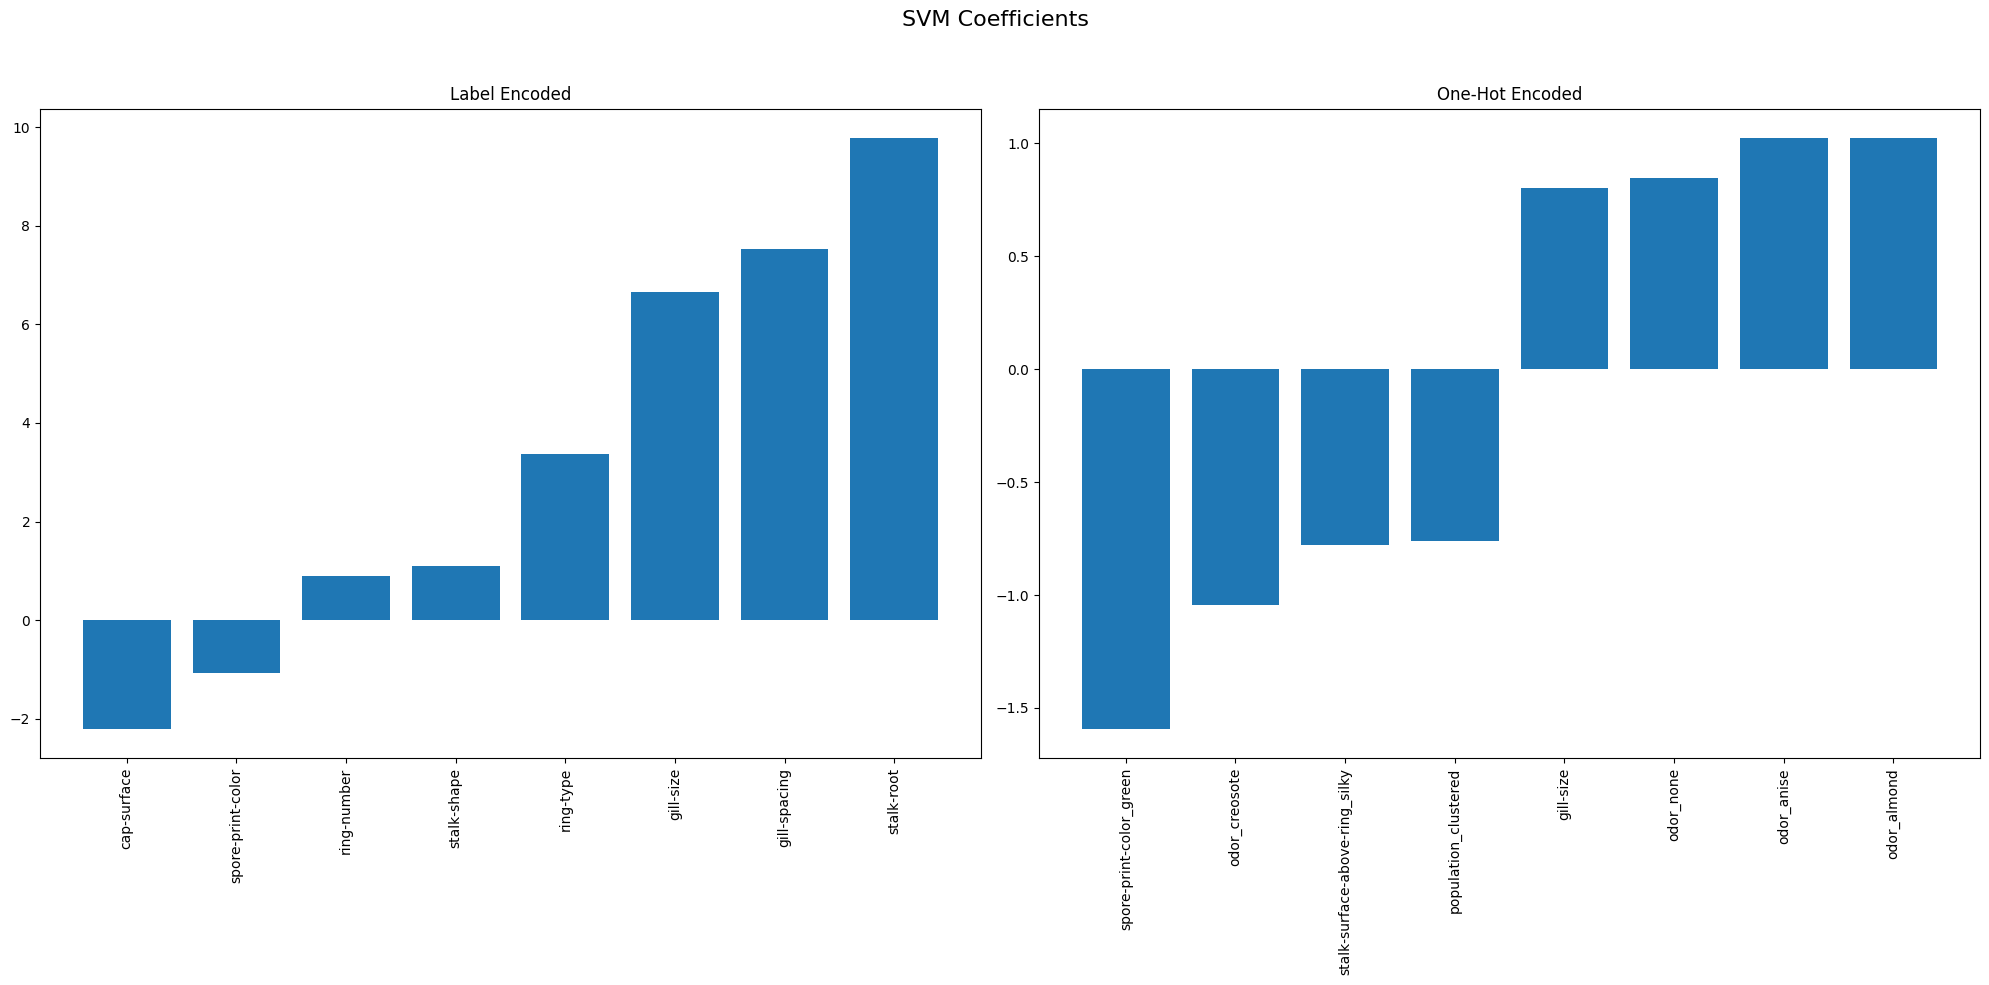

In [24]:
# plot coefficients
fig = plt.figure(figsize=(20,10))
plt.suptitle('SVM Coefficients\n\n', fontsize=16)
ax1 = fig.add_subplot(121)
plt.bar(svm_label_df['Feature'], svm_label_df['Coefficient'])
ax1.title.set_text('Label Encoded')
plt.xticks(rotation=90)
ax2 = fig.add_subplot(122)
plt.bar(svm_onehot_df['Feature'], svm_onehot_df['Coefficient'])
ax2.title.set_text('One-Hot Encoded')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




In the above charts, coefficients with postitive values are most influencial for determining a mushroom is edible, while the negative coefficients show the features that can be used to indicate the mushroom is poisonous. Between the label and one-hot encoding, we see some similarities (spore-print-color and gill-size), but the one-hot encoding features more closely resemble what we observed in Random Forest, namely that odor, gill-size, and silky stalk-surface-above-ring play a large role in determining mushroom class.

## Logistic Regression

For our last classification technique, we will utilize logistic regression, a statistical model that models the probability of a discrete outcome, such as true/false, yes/no, or in this case, eldible/poisonous, given the value of input variables.

In [25]:
# label encoded
lr_label = LogisticRegression(solver="lbfgs", max_iter=1000)
lr_label.fit(X_label, y)
y_label_lr = lr_label.predict(X_label)

# one-hot encoded
lr_onehot = LogisticRegression(solver="lbfgs", max_iter=500)
lr_onehot.fit(X_onehot, y)
y_onehot_lr = lr_onehot.predict(X_onehot)

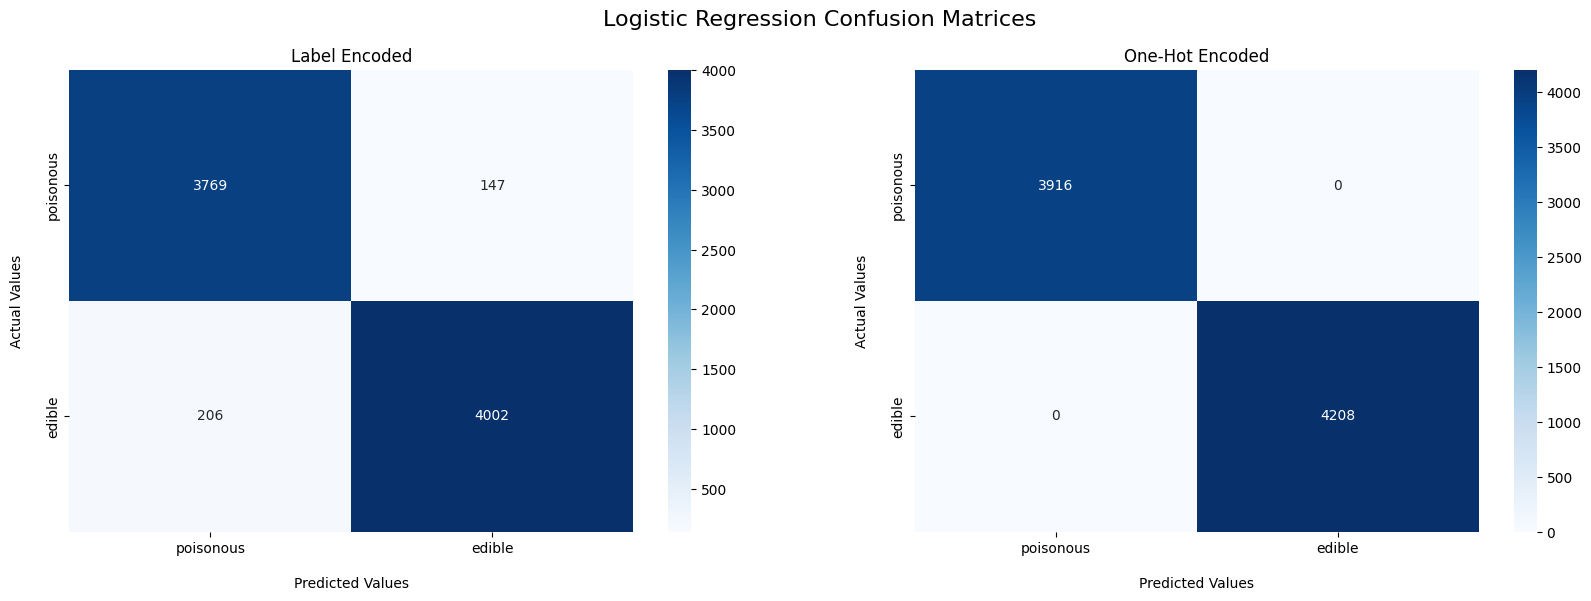

In [26]:
# confusion matrices
lr_label_cm = confusion_matrix(y, y_label_lr)
lr_onehot_cm = confusion_matrix(y, y_onehot_lr)

fig, axs = plt.subplots(1, 2, figsize = (20,6))
fig.suptitle('Logistic Regression Confusion Matrices\n\n', fontsize=16)
sns.heatmap(lr_label_cm, annot=True, cmap='Blues', fmt='g', ax = axs[0])
axs[0].set_title('Label Encoded')
axs[0].set_xlabel('\nPredicted Values')
axs[0].set_ylabel('Actual Values\n')
axs[0].xaxis.set_ticklabels(['poisonous','edible'])
axs[0].yaxis.set_ticklabels(['poisonous','edible'])
sns.heatmap(lr_onehot_cm, annot=True, cmap='Blues', fmt='g', ax=axs[1])
axs[1].set_title('One-Hot Encoded')
axs[1].set_xlabel('\nPredicted Values')
axs[1].set_ylabel('Actual Values\n')
axs[1].xaxis.set_ticklabels(['poisonous','edible'])
axs[1].yaxis.set_ticklabels(['poisonous','edible'])
plt.show()

In [27]:
print('Logistic Regression Reports\n\n')
print('Label Encoded\n')
print(classification_report(y, y_label_lr, target_names=['poisonous','edible']))
print('\n\nOne-Hot Encoded\n')
print(classification_report(y, y_onehot_lr, target_names=['poisonous','edible']))

Logistic Regression Reports


Label Encoded

              precision    recall  f1-score   support

   poisonous       0.95      0.96      0.96      3916
      edible       0.96      0.95      0.96      4208

    accuracy                           0.96      8124
   macro avg       0.96      0.96      0.96      8124
weighted avg       0.96      0.96      0.96      8124



One-Hot Encoded

              precision    recall  f1-score   support

   poisonous       1.00      1.00      1.00      3916
      edible       1.00      1.00      1.00      4208

    accuracy                           1.00      8124
   macro avg       1.00      1.00      1.00      8124
weighted avg       1.00      1.00      1.00      8124



Once again, the one-hot encoding perfoms slightly better than label encoding.



In [28]:
# label encoded
lr_label_coef = lr_label.coef_[0]
lr_label_df = pd.DataFrame(zip(label_features, lr_label_coef), columns=['Feature', 'Coefficient'])
lr_label_df.sort_values(by=['Coefficient'], inplace=True)
lr_label_df = lr_label_df.loc[abs(lr_label_df['Coefficient']) >= 1]

# one-hot encoded
lr_onehot_coef = svm_onehot.coef_[0]
lr_onehot_df = pd.DataFrame(zip(onehot_features, lr_onehot_coef), columns=['Feature', 'Coefficient'])
lr_onehot_df.sort_values(by=['Coefficient'], inplace=True)
lr_onehot_df = lr_onehot_df.loc[abs(lr_onehot_df['Coefficient']) >= 0.65]

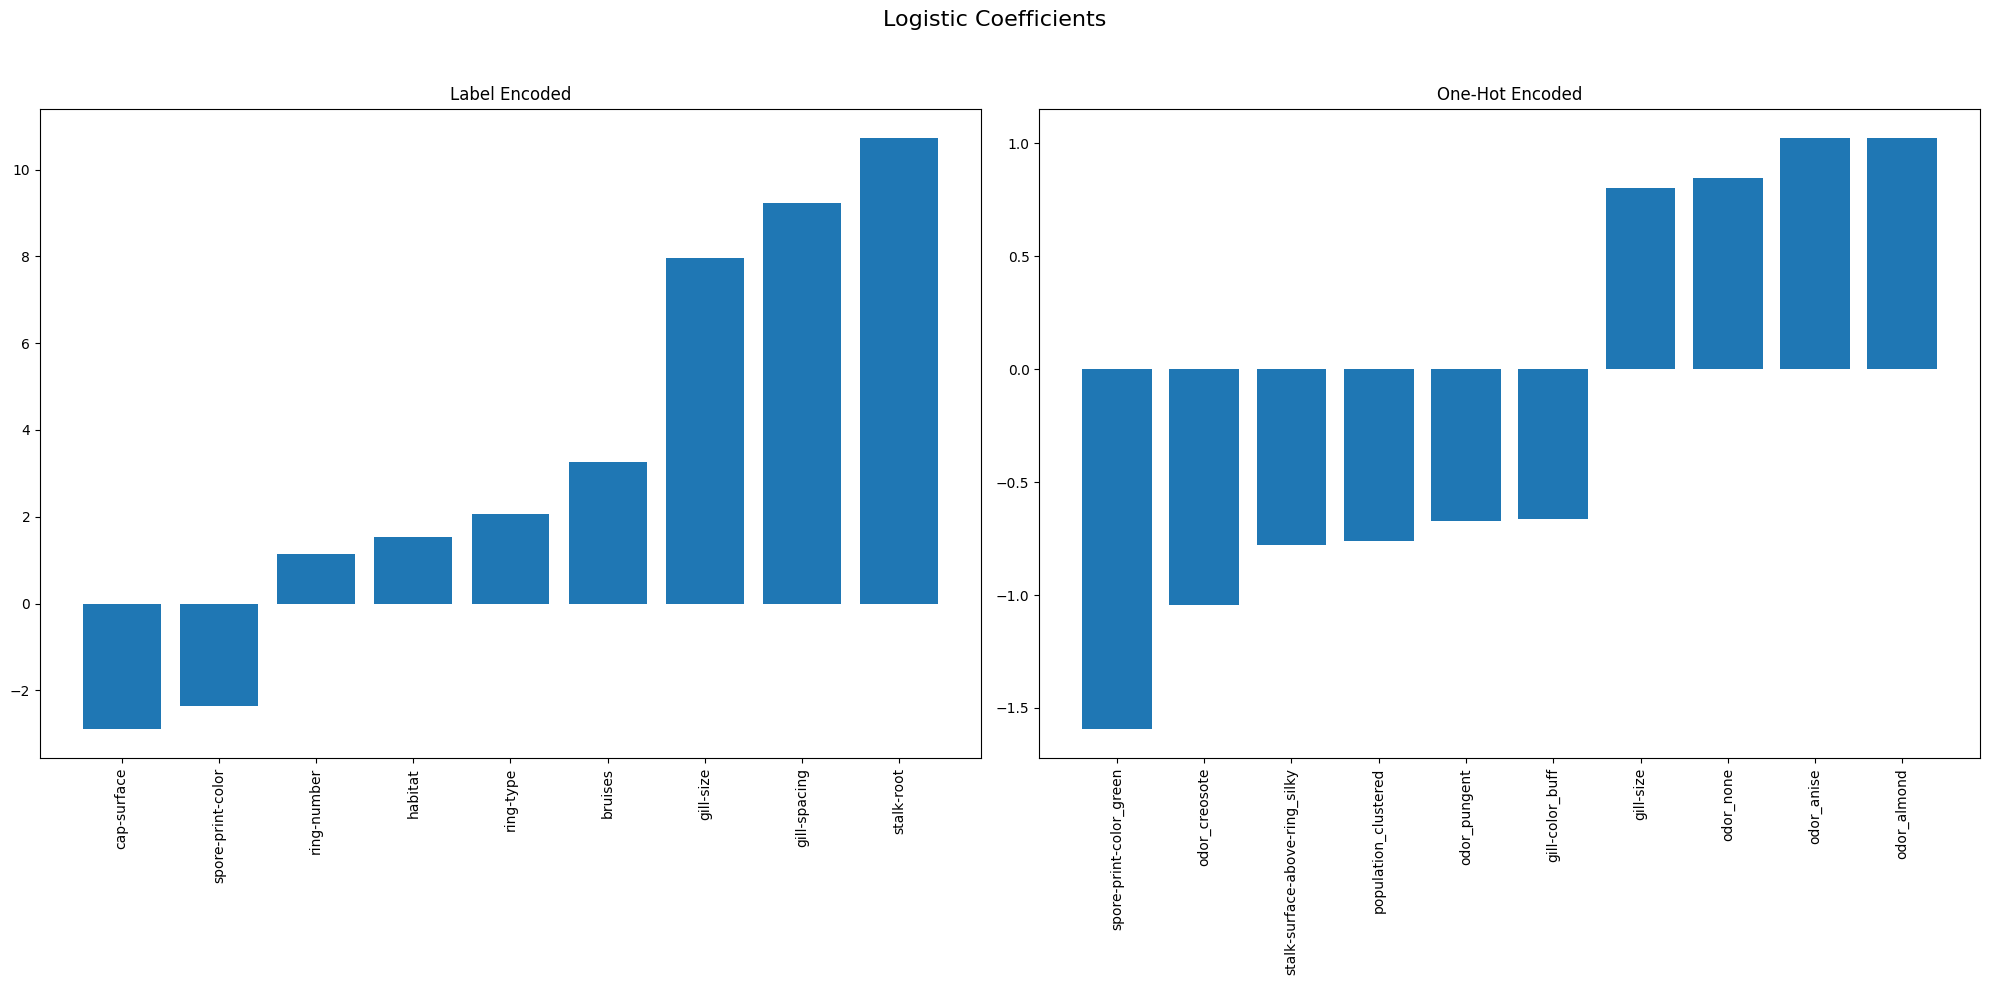

In [29]:
# plot coefficients
fig = plt.figure(figsize=(20,10))
plt.suptitle('Logistic Coefficients\n\n', fontsize=16)
ax1 = fig.add_subplot(121)
plt.bar(lr_label_df['Feature'], lr_label_df['Coefficient'])
ax1.title.set_text('Label Encoded')
plt.xticks(rotation=90)
ax2 = fig.add_subplot(122)
plt.bar(lr_onehot_df['Feature'], lr_onehot_df['Coefficient'])
ax2.title.set_text('One-Hot Encoded')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Similar to coefficient evaluation in SVM, in the above charts, coefficients with postitive values are most influencial for determining a mushroom is edible, while the negative coefficients show the features that can be used to indicate the mushroom is poisonous. Feature importance for logisitc regression appears extremely similar to what we found in SVM classification. However, a few new features pop up. Bruises makes an appearance as an indication of being edible on the label encoded data.

## Conclusion

The description text file of the mushroom dataset provides the following logical rules for determining if a mushroom is poisonous:

	Logical rules for the mushroom data sets.

	Logical rules given below seem to be the simplest possible for the
	mushroom dataset and therefore should be treated as benchmark results.

	Disjunctive rules for poisonous mushrooms, from most general
	to most specific:

	P_1) odor=NOT(almond.OR.anise.OR.none)
	     120 poisonous cases missed, 98.52% accuracy

	P_2) spore-print-color=green
	     48 cases missed, 99.41% accuracy
         
	P_3) odor=none.AND.stalk-surface-below-ring=scaly.AND.
	          (stalk-color-above-ring=NOT.brown) 
	     8 cases missed, 99.90% accuracy
         
	P_4) habitat=leaves.AND.cap-color=white
	         100% accuracy     

	Rule P_4) may also be

	P_4') population=clustered.AND.cap_color=white

Interestingly, rules one and two are quite apparent from our listing of one-hot encoded important features, but rules three and four are not apparent.

Our Random Forest, Support Vector Machines, and Logistic Regression models achieve 100% accuracy using one-hot encoding, but only Random Forest was able to achieve perfect results using label encoding.

For our mushroom stew, it is safe to say we need to stick with mushrooms with anise, almond, or no odor. In conjunction, we want mushrooms with a broad gill-size and bruising. Any buff gill-color or green spore-print-color will send us to an early grave!

